In [1]:
!pip3 install qiskit
!pip3 install qiskit-aer


In [2]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install qiskit_algorithms

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install qiskit_machine_learning


Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install scikit-learn

In [6]:
pip install pylatexenc

Note: you may need to restart the kernel to use updated packages.


In [7]:
import json
import matplotlib.pyplot as plt
import numpy as np
import importlib
import site
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split
from qiskit_aer import Aer

algorithm_globals.random_seed = 12345

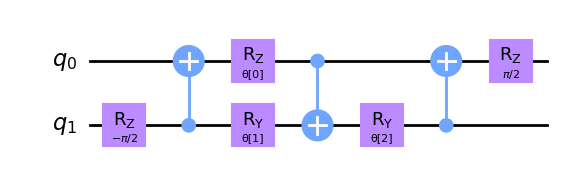

In [8]:
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target


# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl", style="clifford")

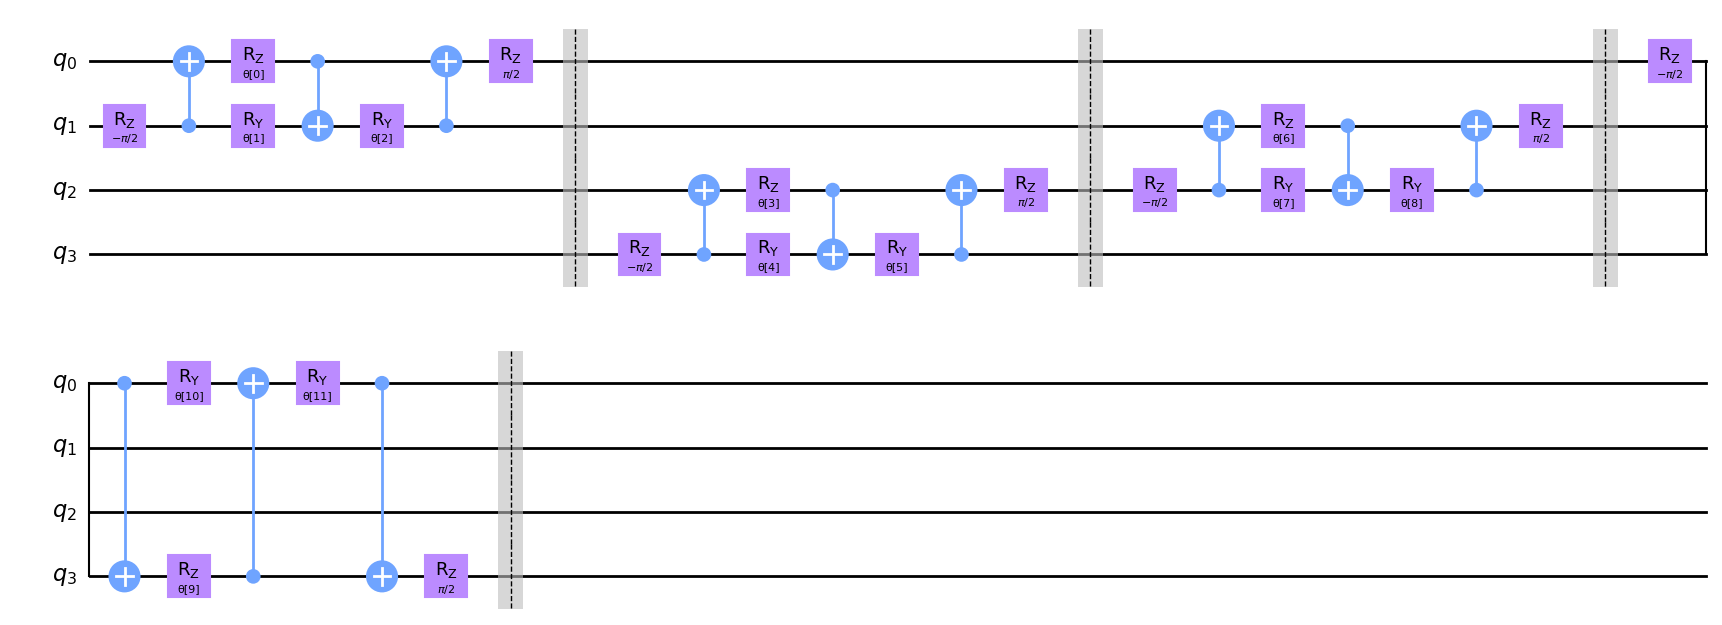

In [9]:
# Now the whole conv layer
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl", style="clifford")

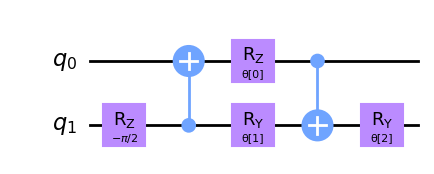

In [10]:
#Pooling layer
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl", style="clifford")

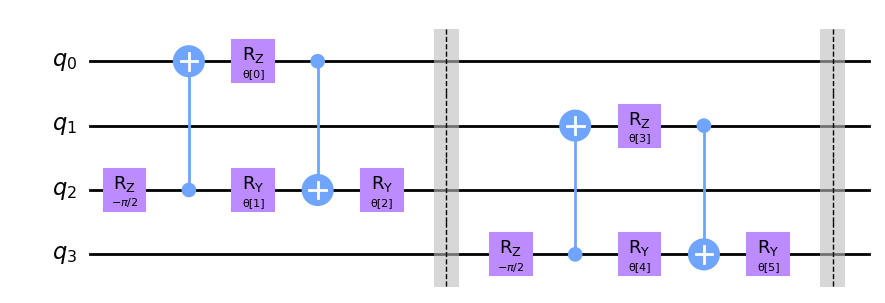

In [11]:
#full pooling layer
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl", style="clifford")

In [12]:
def generate_dataset(num_images):
    images = []
    labels = []
    hor_array = np.zeros((6, 8))
    ver_array = np.zeros((4, 8))

    j = 0
    for i in range(0, 7):
        if i != 3:
            hor_array[j][i] = np.pi / 2
            hor_array[j][i + 1] = np.pi / 2
            j += 1

    j = 0
    for i in range(0, 4):
        ver_array[j][i] = np.pi / 2
        ver_array[j][i + 4] = np.pi / 2
        j += 1

    for n in range(num_images):
        rng = algorithm_globals.random.integers(0, 2)
        if rng == 0:
            labels.append(-1)
            random_image = algorithm_globals.random.integers(0, 6)
            images.append(np.array(hor_array[random_image]))
        elif rng == 1:
            labels.append(1)
            random_image = algorithm_globals.random.integers(0, 4)
            images.append(np.array(ver_array[random_image]))

        # Create noise
        for i in range(8):
            if images[-1][i] == 0:
                images[-1][i] = algorithm_globals.random.uniform(0, np.pi / 4)
    return images, labels

In [13]:
images, labels = generate_dataset(100)

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=246
)

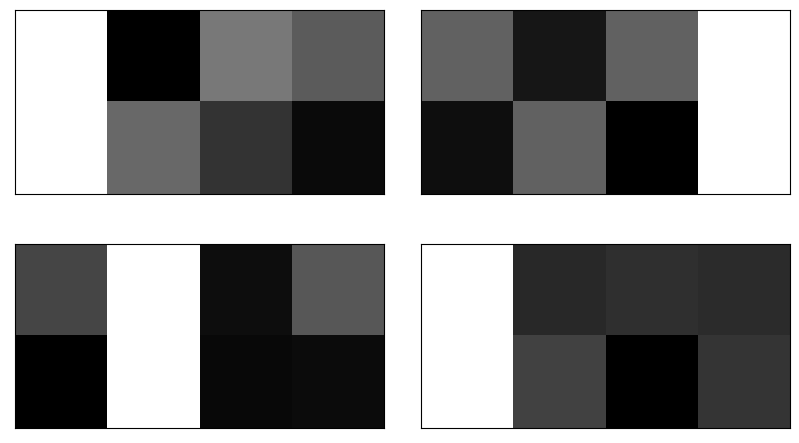

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(4):
    ax[i // 2, i % 2].imshow(
        train_images[i].reshape(2, 4),  # Change back to 2 by 4
        aspect="equal",
        cmap="gray",
    )
plt.subplots_adjust(wspace=0.1, hspace=0.025)

## Now for FRQI:

In [15]:
!pip install qiskit_aer
from qiskit import QuantumRegister, QuantumCircuit, transpile, assemble
from qiskit.visualization import plot_histogram
from numpy import pi
from qiskit_aer import Aer

In [15]:
# Hadamard Gate
def Hadamard(circuit, quantum_register, num_qubits):
    for i in range(num_qubits-1):
        circuit.h(quantum_register[i])

    circuit.barrier()

In [16]:
# Add CNOT, X, and RY Gates
def addGates(circuit, quantum_register, theta, num_qubits):
    for i in range(num_qubits+1):
        if i == 1 or i == 3:
            circuit.x(quantum_register[1])
        elif i == 2:
            circuit.x(quantum_register[0])
            circuit.x(quantum_register[1])

        circuit.cry(theta, quantum_register[0], quantum_register[2])
        circuit.cx(quantum_register[0], quantum_register[1])
        circuit.cry(-theta, quantum_register[1], quantum_register[2])
        circuit.cx(quantum_register[0], quantum_register[1])
        circuit.cry(theta, quantum_register[1], quantum_register[2])

        if i != 3:
            circuit.barrier()

In [17]:
# Add Measurements
def measurements(circuit, quantum_register, num_qubits):
    for i in range(num_qubits):
        circuit.measure(quantum_register[i])

In [18]:
def createFRQI(theta):
    num_qubits = 3
    quantum_reg = QuantumRegister(num_qubits, 'q')
    circuit = QuantumCircuit(quantum_reg)

    Hadamard(circuit, quantum_reg, num_qubits)

    addGates(circuit, quantum_reg, theta, num_qubits)

    circuit.measure_all()

    return circuit


In [20]:
def runSimulation(circuit):
    aer_sim = Aer.get_backend('aer_simulator')
    transpile_circuit = transpile(circuit, aer_sim)
    quantum_obj = assemble(transpile_circuit, shots=4096)
    result = aer_sim.run(quantum_obj).result()
    counts = result.get_counts(circuit)
    
    return counts

## Now pick up the grayscale values of each pixel from the generated dataset:

In [34]:
#since the generated dataset already has the grayscales represented in angles from 0 to pi/2 + pi/4
print (train_images)

[array([1.57079633, 0.07291915, 0.78029634, 0.60947925, 1.57079633,
       0.68193834, 0.37475921, 0.13261341]), array([0.66864267, 0.2404136 , 0.67621344, 1.57079633, 0.19869739,
       0.67029879, 0.11388379, 1.57079633]), array([0.54797808, 1.57079633, 0.23983914, 0.64912836, 0.16734473,
       1.57079633, 0.21613141, 0.22974337]), array([1.57079633, 0.2603306 , 0.29700352, 0.27241453, 1.57079633,
       0.40546628, 0.00706389, 0.33197069]), array([0.76185059, 0.68975164, 1.57079633, 1.57079633, 0.4682751 ,
       0.73590349, 0.49368049, 0.06337375]), array([1.57079633, 1.57079633, 0.15417659, 0.25904314, 0.35985547,
       0.28120719, 0.66636859, 0.42844565]), array([1.57079633, 0.33202099, 0.60036754, 0.32514172, 1.57079633,
       0.48689264, 0.03438432, 0.17257191]), array([0.37519246, 0.60641152, 0.07596607, 0.42483627, 1.57079633,
       1.57079633, 0.58817185, 0.2876974 ]), array([1.57079633, 0.16770857, 0.67782195, 0.26226324, 1.57079633,
       0.5391254 , 0.34194329, 0.360

In [32]:
#print (train_images)